In [ ]:
#Importing the neccessary libraries
import torch
import torchaudio
import os
from pathlib import Path
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torchaudio.functional as F
from IPython.display import Audio, display
import random
import os
from torchaudio.datasets import SPEECHCOMMANDS
from torch import nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

#Checking whether GPU is available or not
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#Loading the dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./",
                                             download=True)

#Checking how many samples are in the dataset
print("Number of samples:", len(dataset))
print(dataset[100000])

#Accessing a randomnly selected sample(Getting to know the data structure and shape of the waveform)
waveform, sample_rate, label,speaker_id, utterance_number = dataset[100000]

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)
print("Label:", label)
print("Speaker ID:", speaker_id)
print("Utterance number:", utterance_number)


cuda
Number of samples: 105829
(tensor([[0.0001, 0.0002, 0.0002,  ..., 0.0016, 0.0014, 0.0011]]), 16000, 'yes', '94d370bf', 2)
Waveform shape: torch.Size([1, 16000])
Sample rate: 16000
Label: yes
Speaker ID: 94d370bf
Utterance number: 2


In [ ]:
#List of desired 10 subclasses
wanted_words = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

#Creating a custom filtered dataset
class SubsetSC(torchaudio.datasets.SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        self._walker = [w for w in self._walker if self._get_label(w) in wanted_words]

    def _get_label(self, fileid):
        return Path(fileid).parent.name

    def __getitem__(self, n):
        waveform, sample_rate, label, *_ = super().__getitem__(n)
        return waveform, sample_rate, label

#Replacing the original dataset with the filtered one
dataset = SubsetSC()
print(len(dataset))

38546


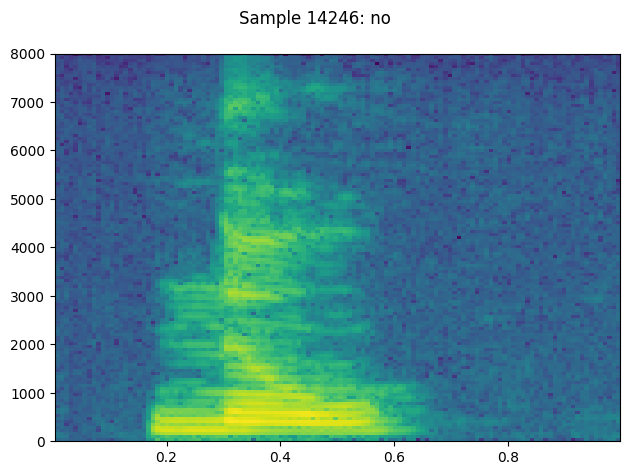

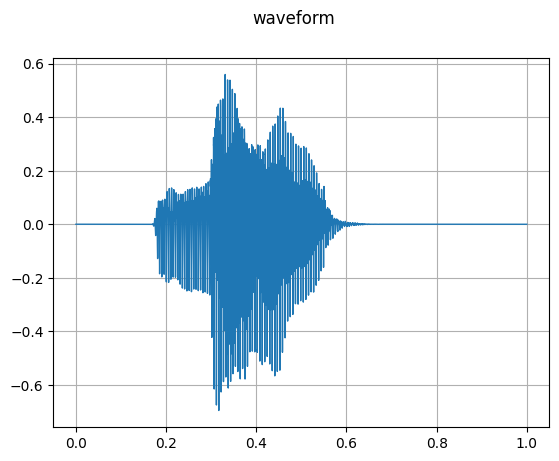

In [ ]:
#Defining the function for plotting the spectogram
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()
    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()

#Defining the function for plotting the waveform of the audio sample
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

i= random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

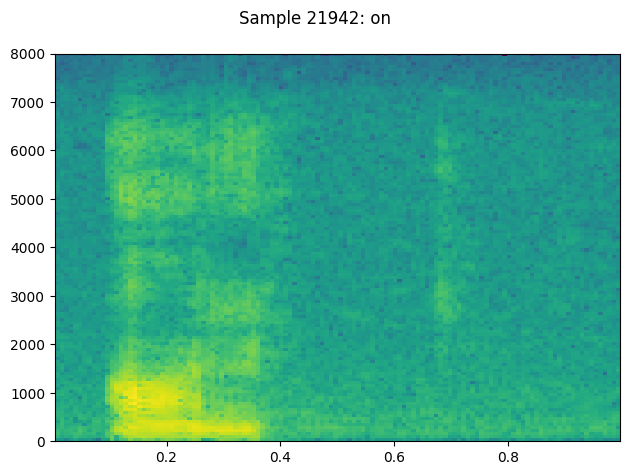

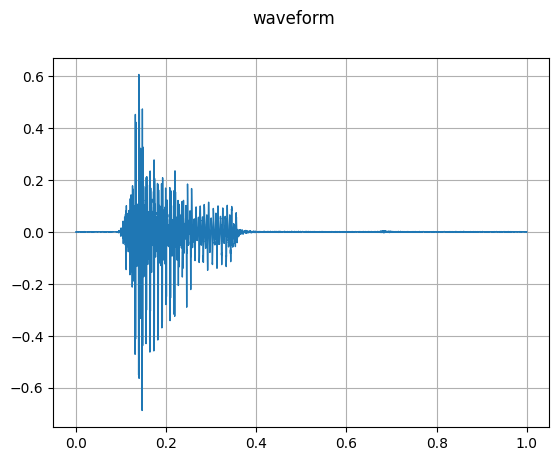

In [ ]:
i = random.randint(0,38546)
waveform, sample_rate, label= dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

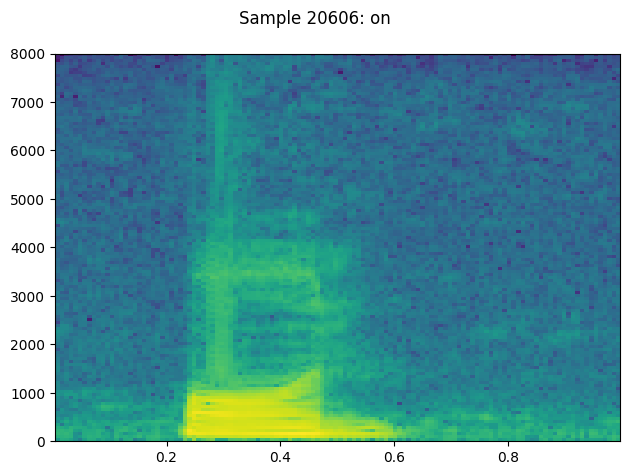

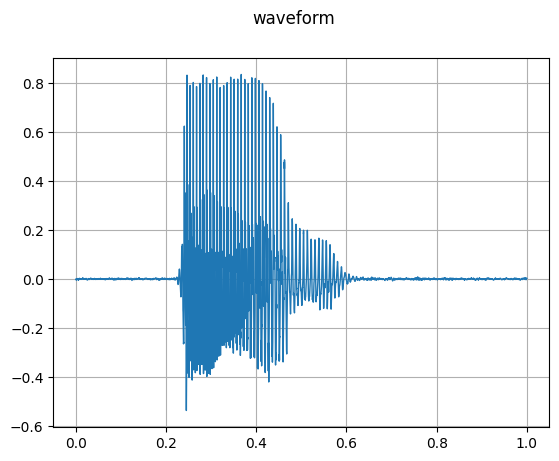

In [ ]:
i = random.randint(0,38546)
waveform, sample_rate, label= dataset[i]
plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
display(Audio(waveform.numpy(), rate=sample_rate))
plot_waveform(waveform, sample_rate)

In [ ]:
#Checking the sampling rate of the audio samples
waveform, sample_rate, label= dataset[1]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [ ]:
waveform, sample_rate, label= dataset[1]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [ ]:
waveform, sample_rate, label= dataset[1]
print("Sample rate:", sample_rate)

Sample rate: 16000


In [ ]:
#Defining the mfcc transform
sample_rate=16000
mfcctransform = torchaudio.transforms.MFCC(
sample_rate=sample_rate,
n_mfcc=40,
melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40, "center": False}).to(device)

#Feature scaling the mfcc transform
def extract_features(waveform):
    mfcc = mfcctransform(waveform).squeeze(0)
    return (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)

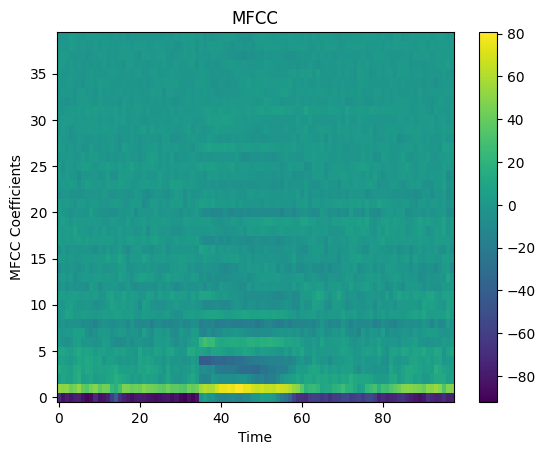

In [ ]:
#Visualizing the mfcc's of random samples
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


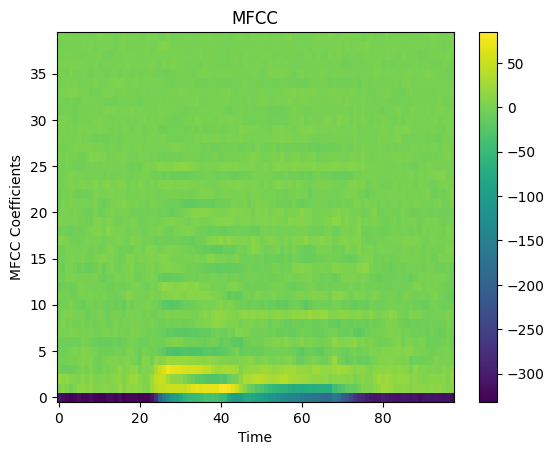

In [ ]:
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


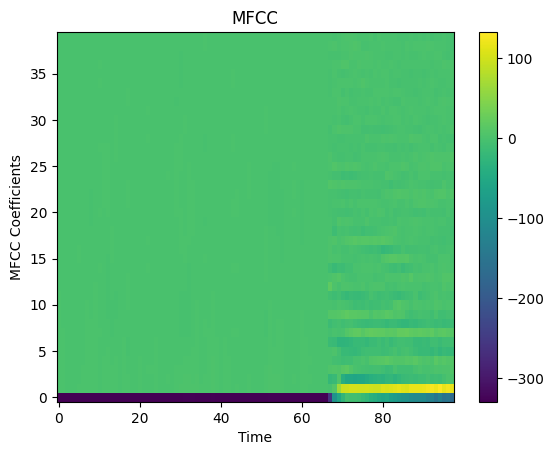

In [ ]:
i=random.randint(0,38546)
waveform, sample_rate, label = dataset[i]
waveform=waveform.to(device)
mfcc = mfcctransform(waveform)
plt.imshow(mfcc[0].cpu().numpy(), cmap="viridis", origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


In [ ]:
#Creating a custom dataset
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as f:
                return [os.path.join(self._path, line.strip()) for line in f]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

target_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_to_index = {label: i for i, label in enumerate(target_labels)}

def label_filter(label):
    return label in target_labels

def label_to_id(label):
    return label_to_index[label]

def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform) * noise_level
    return waveform + noise
def time_stretch(waveform, rate=1.1):
    return torchaudio.functional.resample(waveform, orig_freq=16000, new_freq=int(16000 * rate))
def data_augmentation(waveform, sample_rate=16000):
    if torch.rand(1).item() < 0.5:
        waveform = add_noise(waveform, noise_level=0.01)
    if torch.rand(1).item() < 0.3:
        steps = torch.randint(-2, 3, (1,)).item()  # -2 to +2
    return waveform

class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, subset="training", transform=None, max_length=16000):
        self.data = SubsetSC(subset=subset)
        self.transform = transform
        self.max_length = max_length
        self.augment = self.augment = (subset == "training")

        self.training = (subset == "training")
        self.samples = [(waveform, sample_rate, label) for (waveform, sample_rate, label, *_)
                        in self.data if label_filter(label)]

    def pad_or_truncate(self, waveform):
        length = waveform.shape[1]
        if length > self.max_length:
            return waveform[:, :self.max_length]
        elif length < self.max_length:
            pad_amt = self.max_length - length
            return torch.nn.functional.pad(waveform, (0, pad_amt))
        return waveform

    def __getitem__(self, index):
        waveform, sample_rate, label = self.samples[index]

        if self.augment and self.training:
            waveform = data_augmentation(waveform, sample_rate)

        waveform = self.pad_or_truncate(waveform)
        waveform=waveform.to(device)
        if self.transform:
            waveform = self.transform(waveform)
            waveform = waveform.squeeze(0).transpose(0, 1)
        return waveform, label_to_id(label)

    def __len__(self):
        return len(self.samples)

train_dataset = SubsetDataset(subset="training", transform=extract_features)
val_dataset = SubsetDataset(subset="validation", transform=extract_features)
test_dataset= SubsetDataset(subset="testing", transform=extract_features)

In [ ]:
def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = pad_sequence(waveforms, batch_first=True)
    return waveforms, torch.tensor(labels)


In [ ]:
batch_size=64
train_loader= DataLoader(train_dataset, batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_loader= DataLoader(test_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)
val_dataloader= DataLoader(val_dataset, batch_size=batch_size,shuffle=False,collate_fn=collate_fn)

In [ ]:
#Creating an LSTM Classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, bidirectional=True):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        out, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[-2], h_n[-1]), dim=1) if self.lstm.bidirectional else h_n[-1]
        out = self.dropout(h)
        return self.fc(out)


Epoch 1/15 - Train Loss: 1.7424, Acc: 34.92%, Val Loss: 0.9490, Acc: 64.14%
Epoch 2/15 - Train Loss: 0.6676, Acc: 77.77%, Val Loss: 0.3703, Acc: 87.79%
Epoch 3/15 - Train Loss: 0.4041, Acc: 86.63%, Val Loss: 0.2657, Acc: 91.01%
Epoch 4/15 - Train Loss: 0.2953, Acc: 90.20%, Val Loss: 0.1942, Acc: 93.68%
Epoch 5/15 - Train Loss: 0.2436, Acc: 92.00%, Val Loss: 0.1681, Acc: 94.33%
Epoch 6/15 - Train Loss: 0.2084, Acc: 93.00%, Val Loss: 0.1220, Acc: 96.11%
Epoch 7/15 - Train Loss: 0.1858, Acc: 93.82%, Val Loss: 0.1158, Acc: 96.44%
Epoch 8/15 - Train Loss: 0.1688, Acc: 94.31%, Val Loss: 0.1020, Acc: 96.41%
Epoch 9/15 - Train Loss: 0.1504, Acc: 94.94%, Val Loss: 0.0863, Acc: 97.43%
Epoch 10/15 - Train Loss: 0.1410, Acc: 95.31%, Val Loss: 0.1019, Acc: 96.49%
Epoch 11/15 - Train Loss: 0.1294, Acc: 95.56%, Val Loss: 0.0775, Acc: 97.25%
Epoch 12/15 - Train Loss: 0.1182, Acc: 95.91%, Val Loss: 0.0656, Acc: 97.76%
Epoch 13/15 - Train Loss: 0.1171, Acc: 95.93%, Val Loss: 0.0665, Acc: 97.54%
Epoch 14

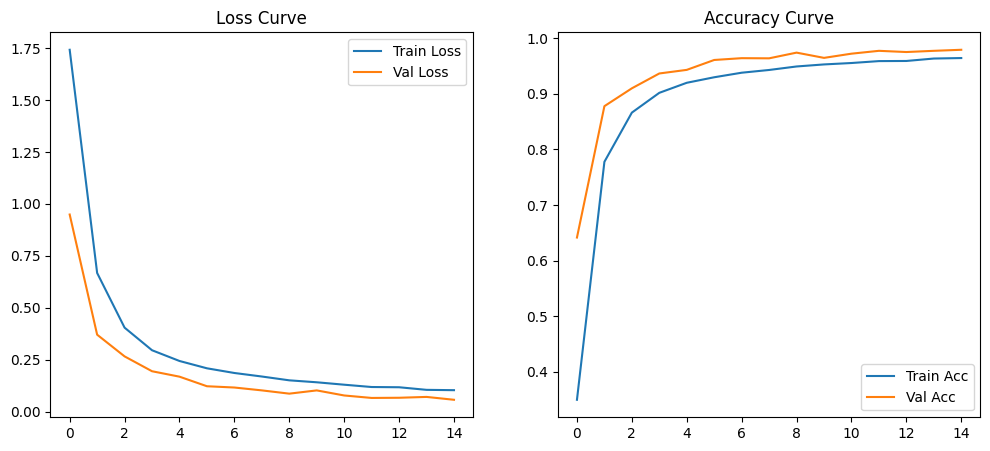

Test Accuracy: 98.40%
F1 Score: 0.9840


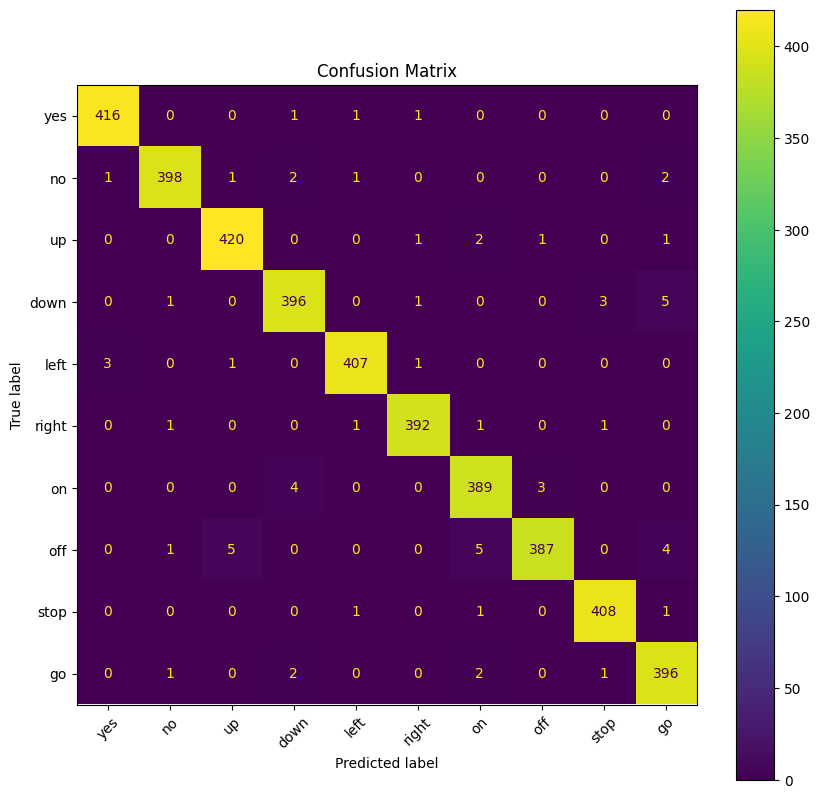

In [ ]:
#Function to train the model
def train_eval(model, train_loader, val_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pred = output.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
                pred = output.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Acc: {train_accs[-1]*100:.2f}%, Val Loss: {val_losses[-1]:.4f}, Acc: {val_accs[-1]*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

model = LSTMClassifier(input_dim=40, hidden_dim=128, output_dim=len(wanted_words)).to(device)
train_losses, val_losses, train_accs, val_accs = train_eval(model, train_loader, val_dataloader, epochs=15)

#Plotting the graphs
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

#Evaluating the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = model(x)
        preds = output.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())
#Printing accuracy and F1 Scores
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {acc*100:.2f}%")
print(f"F1 Score: {f1:.4f}")



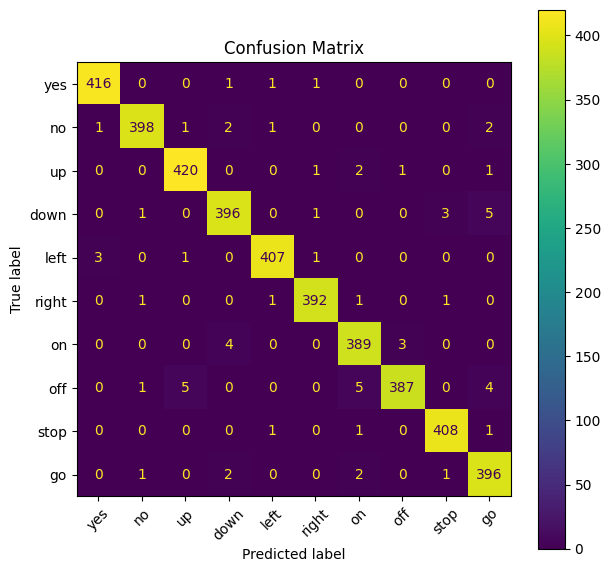

In [ ]:
#Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
display = ConfusionMatrixDisplay(cm, display_labels=wanted_words)
fig, ax = plt.subplots(figsize=(7, 7))
display.plot(xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix")
plt.show()